In [1]:
#import необходимых модулей
import pandas as pd
from itertools import groupby

from datetime import datetime, timedelta
import pandas as pd
import yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, r2_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as m
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from catboost import CatBoostClassifier,CatBoostRegressor, Pool
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [2]:
#Считывание данных в DataFrame 
train= pd.read_csv('train_out.csv', sep=';', index_col=None)
test=pd.read_csv('test_out.csv', sep=';', index_col=None)

In [3]:
train

,Metka,dt,Цена на арматуру
0,меньше,01.12.2015,32500
1,меньше,01.19.2015,32000
2,меньше,01.26.2015,30700
3,меньше,02.02.2015,30300
4,меньше,02.09.2015,30300
...,...,...,...
394,меньше,08.01.2022,47500
395,больше,08.08.2022,49000
396,меньше,08.15.2022,47500
397,меньше,08.22.2022,46500


In [4]:
test

,Цена на арматуру,dt
0,46000,09.05.2022
1,46000,09.12.2022
2,46000,09.19.2022
3,45500,09.26.2022
4,45500,10.03.2022
5,45000,10.10.2022
6,44000,10.17.2022
7,43000,10.24.2022
8,42000,10.31.2022
9,41500,11.07.2022


In [5]:
# Создание признаков по времени
train['Data_Time'] = pd.to_datetime(train.dt)
train['quarter'] = train['Data_Time'].dt.quarter
train['month'] = train['Data_Time'].dt.month
train['year'] = train['Data_Time'].dt.year
train['dayofyear'] = train['Data_Time'].dt.dayofyear
train['dayofmonth'] = train['Data_Time'].dt.day
train['weekofyear'] = train['Data_Time'].dt.isocalendar().week

test['Data_Time'] = pd.to_datetime(test.dt)
test['quarter'] = test['Data_Time'].dt.quarter
test['month'] = test['Data_Time'].dt.month
test['year'] = test['Data_Time'].dt.year
test['dayofyear'] = test['Data_Time'].dt.dayofyear
test['dayofmonth'] = test['Data_Time'].dt.day
test['weekofyear'] = test['Data_Time'].dt.isocalendar().week






In [6]:
# Делаем поля времени трейна и теста категориальными
for col in ['quarter',
       'month',  'weekofyear']:
    test[col] = test[col].astype('category')
    train[col] = train[col].astype('category')

In [7]:
train

,Metka,dt,Цена на арматуру,Data_Time,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,меньше,01.12.2015,32500,2015-01-12,1,1,2015,12,12,3
1,меньше,01.19.2015,32000,2015-01-19,1,1,2015,19,19,4
2,меньше,01.26.2015,30700,2015-01-26,1,1,2015,26,26,5
3,меньше,02.02.2015,30300,2015-02-02,1,2,2015,33,2,6
4,меньше,02.09.2015,30300,2015-02-09,1,2,2015,40,9,7
...,...,...,...,...,...,...,...,...,...,...
394,меньше,08.01.2022,47500,2022-08-01,3,8,2022,213,1,31
395,больше,08.08.2022,49000,2022-08-08,3,8,2022,220,8,32
396,меньше,08.15.2022,47500,2022-08-15,3,8,2022,227,15,33
397,меньше,08.22.2022,46500,2022-08-22,3,8,2022,234,22,34


In [8]:
# распределение бинарные признаков изменения тренда
train['Metka'].value_counts()

меньше    256
больше    143
Name: Metka, dtype: int64

In [9]:
train.columns

Index(['Metka', 'dt', 'Цена на арматуру', 'Data_Time', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [10]:
# набор признаков времени на вход
columns_to_train=['quarter',
       'month',  'year', 'dayofyear', 'dayofmonth', 'weekofyear']

In [11]:
# разбиение на вход и целевую переменную
x_train_all=train[columns_to_train]
y_train_all=train['Metka']

In [12]:
# Определяем веса классов тренда
classes = np.unique(y_train_all)
weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_train_all), y = np.ravel(y_train_all))
class_weights = dict(zip(classes, weights))
class_weights

{'больше': 1.3951048951048952, 'меньше': 0.779296875}

In [13]:
y_train_all

0      меньше
1      меньше
2      меньше
3      меньше
4      меньше
        ...  
394    меньше
395    больше
396    меньше
397    меньше
398    меньше
Name: Metka, Length: 399, dtype: object

In [14]:
# разбиение на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(\
    x_train_all, y_train_all, test_size = 0.15, random_state = 64,stratify=y_train_all)

In [15]:
x_train

,quarter,month,year,dayofyear,dayofmonth,weekofyear
360,4,12,2021,340,6,49
287,3,7,2020,195,13,29
101,4,12,2016,354,19,51
359,4,11,2021,333,29,48
125,2,6,2017,156,5,23
...,...,...,...,...,...,...
74,2,6,2016,165,13,24
297,3,9,2020,265,21,39
346,3,8,2021,242,30,35
215,1,2,2019,56,25,9


In [16]:
y_train

360    меньше
287    больше
101    меньше
359    меньше
125    меньше
        ...  
74     меньше
297    больше
346    меньше
215    больше
258    больше
Name: Metka, Length: 339, dtype: object

In [17]:
x_train.dtypes

quarter       category
month         category
year             int64
dayofyear        int64
dayofmonth       int64
weekofyear    category
dtype: object

In [18]:
# создание пулов кэтбуст
pool_train_solution = Pool(x_train, y_train, cat_features = ['quarter',
       'month',  'weekofyear'])
pool_test_solution = Pool(x_test,y_test, cat_features = ['quarter',
       'month',  'weekofyear'])

In [19]:
# задание параметров модели
model_test = CatBoostClassifier(iterations=5000,bootstrap_type= 'MVS', task_type="CPU",learning_rate=0.015,class_weights={'больше': 1.1, 'меньше': 0.9},
                                loss_function='MultiClass',eval_metric='Accuracy',random_state=88)

In [20]:
# обучение
model_test.fit(pool_train_solution,eval_set=pool_test_solution,early_stopping_rounds=1500)

0:	learn: 0.5958093	test: 0.5856164	best: 0.5856164 (0)	total: 152ms	remaining: 12m 40s
1:	learn: 0.6182812	test: 0.5736301	best: 0.5856164 (0)	total: 198ms	remaining: 8m 13s
2:	learn: 0.6052232	test: 0.5736301	best: 0.5856164 (0)	total: 208ms	remaining: 5m 46s
3:	learn: 0.6261767	test: 0.5890411	best: 0.5890411 (3)	total: 239ms	remaining: 4m 58s
4:	learn: 0.6122077	test: 0.5736301	best: 0.5890411 (3)	total: 269ms	remaining: 4m 28s
5:	learn: 0.6091710	test: 0.5856164	best: 0.5890411 (3)	total: 310ms	remaining: 4m 18s
6:	learn: 0.6058305	test: 0.5856164	best: 0.5890411 (3)	total: 320ms	remaining: 3m 47s
7:	learn: 0.6024901	test: 0.5856164	best: 0.5890411 (3)	total: 332ms	remaining: 3m 27s
8:	learn: 0.5991497	test: 0.5856164	best: 0.5890411 (3)	total: 427ms	remaining: 3m 56s
9:	learn: 0.5991497	test: 0.5856164	best: 0.5890411 (3)	total: 462ms	remaining: 3m 50s
10:	learn: 0.5991497	test: 0.5856164	best: 0.5890411 (3)	total: 511ms	remaining: 3m 51s
11:	learn: 0.6058305	test: 0.5856164	best

95:	learn: 0.6125114	test: 0.5856164	best: 0.5890411 (3)	total: 2.68s	remaining: 2m 16s
96:	learn: 0.6125114	test: 0.5856164	best: 0.5890411 (3)	total: 2.71s	remaining: 2m 16s
97:	learn: 0.6091710	test: 0.5856164	best: 0.5890411 (3)	total: 2.74s	remaining: 2m 16s
98:	learn: 0.6091710	test: 0.5856164	best: 0.5890411 (3)	total: 2.75s	remaining: 2m 16s
99:	learn: 0.6125114	test: 0.5856164	best: 0.5890411 (3)	total: 2.78s	remaining: 2m 16s
100:	learn: 0.6158518	test: 0.5856164	best: 0.5890411 (3)	total: 2.81s	remaining: 2m 16s
101:	learn: 0.6225326	test: 0.5856164	best: 0.5890411 (3)	total: 2.84s	remaining: 2m 16s
102:	learn: 0.6225326	test: 0.5856164	best: 0.5890411 (3)	total: 2.87s	remaining: 2m 16s
103:	learn: 0.6225326	test: 0.5856164	best: 0.5890411 (3)	total: 2.91s	remaining: 2m 16s
104:	learn: 0.6191922	test: 0.5856164	best: 0.5890411 (3)	total: 2.95s	remaining: 2m 17s
105:	learn: 0.6125114	test: 0.5856164	best: 0.5890411 (3)	total: 2.98s	remaining: 2m 17s
106:	learn: 0.6191922	test

193:	learn: 0.6738536	test: 0.5856164	best: 0.5890411 (3)	total: 5.08s	remaining: 2m 5s
194:	learn: 0.6738536	test: 0.5856164	best: 0.5890411 (3)	total: 5.08s	remaining: 2m 5s
195:	learn: 0.6677801	test: 0.5856164	best: 0.5890411 (3)	total: 5.13s	remaining: 2m 5s
196:	learn: 0.6778014	test: 0.5856164	best: 0.5890411 (3)	total: 5.16s	remaining: 2m 5s
197:	learn: 0.6778014	test: 0.5856164	best: 0.5890411 (3)	total: 5.19s	remaining: 2m 5s
198:	learn: 0.6778014	test: 0.5856164	best: 0.5890411 (3)	total: 5.2s	remaining: 2m 5s
199:	learn: 0.6811418	test: 0.5856164	best: 0.5890411 (3)	total: 5.23s	remaining: 2m 5s
200:	learn: 0.6811418	test: 0.5856164	best: 0.5890411 (3)	total: 5.25s	remaining: 2m 5s
201:	learn: 0.6811418	test: 0.5856164	best: 0.5890411 (3)	total: 5.28s	remaining: 2m 5s
202:	learn: 0.6844822	test: 0.5856164	best: 0.5890411 (3)	total: 5.32s	remaining: 2m 5s
203:	learn: 0.6878226	test: 0.5856164	best: 0.5890411 (3)	total: 5.34s	remaining: 2m 5s
204:	learn: 0.6878226	test: 0.585

288:	learn: 0.7379289	test: 0.5856164	best: 0.5890411 (3)	total: 7.72s	remaining: 2m 5s
289:	learn: 0.7412694	test: 0.5856164	best: 0.5890411 (3)	total: 7.75s	remaining: 2m 5s
290:	learn: 0.7412694	test: 0.5856164	best: 0.5890411 (3)	total: 7.78s	remaining: 2m 5s
291:	learn: 0.7412694	test: 0.5856164	best: 0.5890411 (3)	total: 7.81s	remaining: 2m 5s
292:	learn: 0.7412694	test: 0.5856164	best: 0.5890411 (3)	total: 7.82s	remaining: 2m 5s
293:	learn: 0.7412694	test: 0.5856164	best: 0.5890411 (3)	total: 7.82s	remaining: 2m 5s
294:	learn: 0.7412694	test: 0.5856164	best: 0.5890411 (3)	total: 7.84s	remaining: 2m 5s
295:	learn: 0.7412694	test: 0.5856164	best: 0.5890411 (3)	total: 7.87s	remaining: 2m 4s
296:	learn: 0.7412694	test: 0.5856164	best: 0.5890411 (3)	total: 7.88s	remaining: 2m 4s
297:	learn: 0.7385363	test: 0.5856164	best: 0.5890411 (3)	total: 7.91s	remaining: 2m 4s
298:	learn: 0.7385363	test: 0.5856164	best: 0.5890411 (3)	total: 7.94s	remaining: 2m 4s
299:	learn: 0.7385363	test: 0.58

384:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 10.4s	remaining: 2m 4s
385:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 10.4s	remaining: 2m 4s
386:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 10.5s	remaining: 2m 4s
387:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 10.5s	remaining: 2m 4s
388:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 10.5s	remaining: 2m 4s
389:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 10.6s	remaining: 2m 4s
390:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 10.6s	remaining: 2m 4s
391:	learn: 0.7819617	test: 0.5890411	best: 0.6044520 (302)	total: 10.6s	remaining: 2m 4s
392:	learn: 0.7786213	test: 0.5890411	best: 0.6044520 (302)	total: 10.6s	remaining: 2m 4s
393:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 10.7s	remaining: 2m 4s
394:	learn: 0.7786213	test: 0.5890411	best: 0.6044520 (302)	total: 10.7s	remaining: 2m 4s
395:	learn

483:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 13.3s	remaining: 2m 4s
484:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 13.3s	remaining: 2m 4s
485:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 13.4s	remaining: 2m 4s
486:	learn: 0.8059520	test: 0.5924657	best: 0.6078767 (458)	total: 13.4s	remaining: 2m 4s
487:	learn: 0.8092924	test: 0.5924657	best: 0.6078767 (458)	total: 13.4s	remaining: 2m 4s
488:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 13.5s	remaining: 2m 4s
489:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 13.5s	remaining: 2m 4s
490:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 13.5s	remaining: 2m 4s
491:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 13.5s	remaining: 2m 4s
492:	learn: 0.8159733	test: 0.5924657	best: 0.6078767 (458)	total: 13.6s	remaining: 2m 4s
493:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 13.6s	remaining: 2m 4s
494:	learn

578:	learn: 0.8460370	test: 0.6113014	best: 0.6113014 (578)	total: 16.3s	remaining: 2m 4s
579:	learn: 0.8460370	test: 0.6301370	best: 0.6301370 (579)	total: 16.3s	remaining: 2m 4s
580:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 16.4s	remaining: 2m 4s
581:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 16.4s	remaining: 2m 4s
582:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 16.4s	remaining: 2m 4s
583:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 16.5s	remaining: 2m 4s
584:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 16.5s	remaining: 2m 4s
585:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 16.5s	remaining: 2m 4s
586:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 16.6s	remaining: 2m 4s
587:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 16.6s	remaining: 2m 4s
588:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 16.6s	remaining: 2m 4s
589:	learn

671:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 19.5s	remaining: 2m 5s
672:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 19.6s	remaining: 2m 5s
673:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 19.6s	remaining: 2m 5s
674:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 19.6s	remaining: 2m 5s
675:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 19.7s	remaining: 2m 5s
676:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 19.7s	remaining: 2m 5s
677:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 19.8s	remaining: 2m 5s
678:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 19.8s	remaining: 2m 5s
679:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 19.8s	remaining: 2m 5s
680:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 19.9s	remaining: 2m 5s
681:	learn: 0.8888551	test: 0.6301370	best: 0.6301370 (579)	total: 19.9s	remaining: 2m 5s
682:	learn

766:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.5s	remaining: 2m 4s
767:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.5s	remaining: 2m 4s
768:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.6s	remaining: 2m 4s
769:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.6s	remaining: 2m 4s
770:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.6s	remaining: 2m 4s
771:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.7s	remaining: 2m 4s
772:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.7s	remaining: 2m 4s
773:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.7s	remaining: 2m 4s
774:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.8s	remaining: 2m 4s
775:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.8s	remaining: 2m 4s
776:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 22.9s	remaining: 2m 4s
777:	learn

859:	learn: 0.9222593	test: 0.6181507	best: 0.6301370 (579)	total: 26.2s	remaining: 2m 5s
860:	learn: 0.9222593	test: 0.5993151	best: 0.6301370 (579)	total: 26.2s	remaining: 2m 5s
861:	learn: 0.9255998	test: 0.6181507	best: 0.6301370 (579)	total: 26.2s	remaining: 2m 5s
862:	learn: 0.9255998	test: 0.6181507	best: 0.6301370 (579)	total: 26.2s	remaining: 2m 5s
863:	learn: 0.9222593	test: 0.6181507	best: 0.6301370 (579)	total: 26.3s	remaining: 2m 5s
864:	learn: 0.9255998	test: 0.6181507	best: 0.6301370 (579)	total: 26.3s	remaining: 2m 5s
865:	learn: 0.9255998	test: 0.6181507	best: 0.6301370 (579)	total: 26.3s	remaining: 2m 5s
866:	learn: 0.9255998	test: 0.6181507	best: 0.6301370 (579)	total: 26.4s	remaining: 2m 5s
867:	learn: 0.9255998	test: 0.6181507	best: 0.6301370 (579)	total: 26.4s	remaining: 2m 5s
868:	learn: 0.9255998	test: 0.6181507	best: 0.6301370 (579)	total: 26.4s	remaining: 2m 5s
869:	learn: 0.9222593	test: 0.6181507	best: 0.6301370 (579)	total: 26.4s	remaining: 2m 5s
870:	learn

954:	learn: 0.9356210	test: 0.6215753	best: 0.6301370 (579)	total: 29.4s	remaining: 2m 4s
955:	learn: 0.9356210	test: 0.6215753	best: 0.6301370 (579)	total: 29.4s	remaining: 2m 4s
956:	learn: 0.9356210	test: 0.6215753	best: 0.6301370 (579)	total: 29.5s	remaining: 2m 4s
957:	learn: 0.9356210	test: 0.6215753	best: 0.6301370 (579)	total: 29.5s	remaining: 2m 4s
958:	learn: 0.9356210	test: 0.6215753	best: 0.6301370 (579)	total: 29.6s	remaining: 2m 4s
959:	learn: 0.9356210	test: 0.6215753	best: 0.6301370 (579)	total: 29.7s	remaining: 2m 4s
960:	learn: 0.9356210	test: 0.6215753	best: 0.6301370 (579)	total: 29.7s	remaining: 2m 4s
961:	learn: 0.9356210	test: 0.6215753	best: 0.6301370 (579)	total: 29.8s	remaining: 2m 5s
962:	learn: 0.9383541	test: 0.6215753	best: 0.6301370 (579)	total: 29.8s	remaining: 2m 5s
963:	learn: 0.9383541	test: 0.6215753	best: 0.6301370 (579)	total: 29.9s	remaining: 2m 5s
964:	learn: 0.9383541	test: 0.6215753	best: 0.6301370 (579)	total: 30s	remaining: 2m 5s
965:	learn: 

1049:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.6s	remaining: 2m 2s
1050:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.6s	remaining: 2m 2s
1051:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.6s	remaining: 2m 2s
1052:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.7s	remaining: 2m 2s
1053:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.7s	remaining: 2m 2s
1054:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.7s	remaining: 2m 2s
1055:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.8s	remaining: 2m 2s
1056:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.8s	remaining: 2m 2s
1057:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.8s	remaining: 2m 2s
1058:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.9s	remaining: 2m 2s
1059:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.9s	remaining: 2m 2s

1140:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.3s	remaining: 1m 59s
1141:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.3s	remaining: 1m 59s
1142:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.4s	remaining: 1m 59s
1143:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.4s	remaining: 1m 59s
1144:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.4s	remaining: 1m 59s
1145:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.5s	remaining: 1m 59s
1146:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.5s	remaining: 1m 59s
1147:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.5s	remaining: 1m 59s
1148:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.5s	remaining: 1m 59s
1149:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.6s	remaining: 1m 59s
1150:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.6s	remain

1232:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.2s	remaining: 1m 56s
1233:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.3s	remaining: 1m 56s
1234:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.3s	remaining: 1m 56s
1235:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.3s	remaining: 1m 56s
1236:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.4s	remaining: 1m 56s
1237:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.4s	remaining: 1m 56s
1238:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.4s	remaining: 1m 56s
1239:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.5s	remaining: 1m 56s
1240:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.5s	remaining: 1m 56s
1241:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.5s	remaining: 1m 56s
1242:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38.6s	remain

1324:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 41.2s	remaining: 1m 54s
1325:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 41.2s	remaining: 1m 54s
1326:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 41.2s	remaining: 1m 54s
1327:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 41.2s	remaining: 1m 54s
1328:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 41.3s	remaining: 1m 53s
1329:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 41.3s	remaining: 1m 53s
1330:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 41.3s	remaining: 1m 53s
1331:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 41.4s	remaining: 1m 53s
1332:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 41.4s	remaining: 1m 53s
1333:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 41.4s	remaining: 1m 53s
1334:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 41.4s	remain

1418:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.1s	remaining: 1m 51s
1419:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.1s	remaining: 1m 51s
1420:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.1s	remaining: 1m 51s
1421:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.2s	remaining: 1m 51s
1422:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.2s	remaining: 1m 51s
1423:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.2s	remaining: 1m 51s
1424:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.3s	remaining: 1m 51s
1425:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.3s	remaining: 1m 50s
1426:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.3s	remaining: 1m 50s
1427:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.3s	remaining: 1m 50s
1428:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 44.4s	remain

1510:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.9s	remaining: 1m 48s
1511:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 47s	remaining: 1m 48s
1512:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 47s	remaining: 1m 48s
1513:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 47s	remaining: 1m 48s
1514:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 47s	remaining: 1m 48s
1515:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 47.1s	remaining: 1m 48s
1516:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 47.1s	remaining: 1m 48s
1517:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 47.1s	remaining: 1m 48s
1518:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 47.2s	remaining: 1m 48s
1519:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 47.2s	remaining: 1m 48s
1520:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 47.2s	rem

1604:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 50.1s	remaining: 1m 46s
1605:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 50.2s	remaining: 1m 46s
1606:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 50.2s	remaining: 1m 45s
1607:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 50.2s	remaining: 1m 45s
1608:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 50.2s	remaining: 1m 45s
1609:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 50.3s	remaining: 1m 45s
1610:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 50.3s	remaining: 1m 45s
1611:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 50.3s	remaining: 1m 45s
1612:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 50.4s	remaining: 1m 45s
1613:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 50.4s	remaining: 1m 45s
1614:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 5

1696:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 53s	remaining: 1m 43s
1697:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 53s	remaining: 1m 43s
1698:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 53.1s	remaining: 1m 43s
1699:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 53.1s	remaining: 1m 43s
1700:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 53.1s	remaining: 1m 43s
1701:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 53.1s	remaining: 1m 42s
1702:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 53.2s	remaining: 1m 42s
1703:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 53.2s	remaining: 1m 42s
1704:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 53.3s	remaining: 1m 42s
1705:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 53.3s	remaining: 1m 42s
1706:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 53.3s

1787:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 56.2s	remaining: 1m 40s
1788:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 56.2s	remaining: 1m 40s
1789:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 56.3s	remaining: 1m 40s
1790:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 56.3s	remaining: 1m 40s
1791:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 56.3s	remaining: 1m 40s
1792:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 56.4s	remaining: 1m 40s
1793:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 56.4s	remaining: 1m 40s
1794:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 56.4s	remaining: 1m 40s
1795:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 56.5s	remaining: 1m 40s
1796:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 56.5s	remaining: 1m 40s
1797:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 5

1879:	learn: 0.9839053	test: 0.6558219	best: 0.6558219 (1869)	total: 59.5s	remaining: 1m 38s
1880:	learn: 0.9839053	test: 0.6404110	best: 0.6558219 (1869)	total: 59.5s	remaining: 1m 38s
1881:	learn: 0.9839053	test: 0.6404110	best: 0.6558219 (1869)	total: 59.6s	remaining: 1m 38s
1882:	learn: 0.9839053	test: 0.6404110	best: 0.6558219 (1869)	total: 59.6s	remaining: 1m 38s
1883:	learn: 0.9839053	test: 0.6592466	best: 0.6592466 (1883)	total: 59.6s	remaining: 1m 38s
1884:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 59.7s	remaining: 1m 38s
1885:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 59.7s	remaining: 1m 38s
1886:	learn: 0.9839053	test: 0.6558219	best: 0.6592466 (1883)	total: 59.8s	remaining: 1m 38s
1887:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 59.8s	remaining: 1m 38s
1888:	learn: 0.9839053	test: 0.6558219	best: 0.6592466 (1883)	total: 59.8s	remaining: 1m 38s
1889:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 5

1974:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 36s
1975:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 36s
1976:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 36s
1977:	learn: 0.9872457	test: 0.6592466	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 36s
1978:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 36s
1979:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 36s
1980:	learn: 0.9872457	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 35s
1981:	learn: 0.9872457	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 3s	remaining: 1m 35s
1982:	learn: 0.9872457	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 3s	remaining: 1m 35s
1983:	learn: 0.9872457	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 3s	remaining: 1m 35s
1984:	learn: 0.9872457	test: 0.6780822	best: 0.6934931 (1961)	total: 1

2065:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 5s	remaining: 1m 33s
2066:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 5s	remaining: 1m 33s
2067:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 5s	remaining: 1m 33s
2068:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 5s	remaining: 1m 33s
2069:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 5s	remaining: 1m 33s
2070:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 5s	remaining: 1m 33s
2071:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 5s	remaining: 1m 33s
2072:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 5s	remaining: 1m 33s
2073:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 5s	remaining: 1m 33s
2074:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 33s
2075:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1

2156:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 9s	remaining: 1m 31s
2157:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 9s	remaining: 1m 31s
2158:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 9s	remaining: 1m 31s
2159:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 9s	remaining: 1m 31s
2160:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 9s	remaining: 1m 31s
2161:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 9s	remaining: 1m 31s
2162:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 9s	remaining: 1m 31s
2163:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 9s	remaining: 1m 31s
2164:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 9s	remaining: 1m 31s
2165:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 9s	remaining: 1m 30s
2166:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1

2248:	learn: 0.9933192	test: 0.6592466	best: 0.6934931 (1961)	total: 1m 12s	remaining: 1m 28s
2249:	learn: 0.9933192	test: 0.6592466	best: 0.6934931 (1961)	total: 1m 12s	remaining: 1m 28s
2250:	learn: 0.9933192	test: 0.6592466	best: 0.6934931 (1961)	total: 1m 12s	remaining: 1m 28s
2251:	learn: 0.9933192	test: 0.6592466	best: 0.6934931 (1961)	total: 1m 12s	remaining: 1m 28s
2252:	learn: 0.9933192	test: 0.6592466	best: 0.6934931 (1961)	total: 1m 12s	remaining: 1m 28s
2253:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961)	total: 1m 12s	remaining: 1m 28s
2254:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961)	total: 1m 12s	remaining: 1m 28s
2255:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961)	total: 1m 12s	remaining: 1m 28s
2256:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961)	total: 1m 12s	remaining: 1m 28s
2257:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961)	total: 1m 12s	remaining: 1m 28s
2258:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961

2341:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 27s
2342:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 27s
2343:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 27s
2344:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 27s
2345:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 27s
2346:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 27s
2347:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 27s
2348:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 27s
2349:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 27s
2350:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 27s
2351:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961

2431:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 20s	remaining: 1m 25s
2432:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 20s	remaining: 1m 25s
2433:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 20s	remaining: 1m 25s
2434:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 20s	remaining: 1m 25s
2435:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 20s	remaining: 1m 25s
2436:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 20s	remaining: 1m 25s
2437:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 20s	remaining: 1m 25s
2438:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 21s	remaining: 1m 25s
2439:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 21s	remaining: 1m 25s
2440:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 21s	remaining: 1m 25s
2441:	learn: 0.9966596	test: 0.6626712	best: 0.6934931 (1961

2523:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 24s	remaining: 1m 22s
2524:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 24s	remaining: 1m 22s
2525:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 24s	remaining: 1m 22s
2526:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 24s	remaining: 1m 22s
2527:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 24s	remaining: 1m 22s
2528:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 24s	remaining: 1m 22s
2529:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 24s	remaining: 1m 22s
2530:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 24s	remaining: 1m 22s
2531:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 24s	remaining: 1m 22s
2532:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 24s	remaining: 1m 22s
2533:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961

2614:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 27s	remaining: 1m 19s
2615:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 27s	remaining: 1m 19s
2616:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 27s	remaining: 1m 19s
2617:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 27s	remaining: 1m 19s
2618:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 27s	remaining: 1m 19s
2619:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 27s	remaining: 1m 19s
2620:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 27s	remaining: 1m 19s
2621:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 27s	remaining: 1m 19s
2622:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 27s	remaining: 1m 19s
2623:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 27s	remaining: 1m 19s
2624:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961

2702:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 16s
2703:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 16s
2704:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 16s
2705:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 16s
2706:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 16s
2707:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 16s
2708:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 16s
2709:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 16s
2710:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 16s
2711:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 16s
2712:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961

2790:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 14s
2791:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 13s
2792:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 13s
2793:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 13s
2794:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 13s
2795:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 13s
2796:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 13s
2797:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 13s
2798:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 13s
2799:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 13s
2800:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961

2884:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 10s
2885:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 10s
2886:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 10s
2887:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 10s
2888:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 10s
2889:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 10s
2890:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 37s	remaining: 1m 10s
2891:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 37s	remaining: 1m 10s
2892:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 37s	remaining: 1m 10s
2893:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 37s	remaining: 1m 10s
2894:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961

2977:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 7s
2978:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 7s
2979:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 7s
2980:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 7s
2981:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 7s
2982:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 40s	remaining: 1m 7s
2983:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 40s	remaining: 1m 7s
2984:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 40s	remaining: 1m 7s
2985:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 40s	remaining: 1m 7s
2986:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 40s	remaining: 1m 7s
2987:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1

3071:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 4s
3072:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 4s
3073:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 4s
3074:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 4s
3075:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 4s
3076:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 4s
3077:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 4s
3078:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 43s	remaining: 1m 4s
3079:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 43s	remaining: 1m 4s
3080:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 43s	remaining: 1m 4s
3081:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1

3164:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 1s
3165:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 1s
3166:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 1s
3167:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 1s
3168:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 1s
3169:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 1s
3170:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 1s
3171:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 1s
3172:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m
3173:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m
3174:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	

3254:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 58.2s
3255:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 58.1s
3256:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 58.1s
3257:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 58.1s
3258:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 58s
3259:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 58s
3260:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 58s
3261:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 57.9s
3262:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 57.9s
3263:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 57.9s
3264:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	

3348:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 54.9s
3349:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 54.9s
3350:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 54.8s
3351:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 54.8s
3352:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 54.8s
3353:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 54.7s
3354:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 54.7s
3355:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 54.6s
3356:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 54.6s
3357:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 54.6s
3358:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1

3438:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 54s	remaining: 51.8s
3439:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 54s	remaining: 51.7s
3440:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 54s	remaining: 51.7s
3441:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 54s	remaining: 51.7s
3442:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 54s	remaining: 51.6s
3443:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 54s	remaining: 51.6s
3444:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 54s	remaining: 51.5s
3445:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 54s	remaining: 51.5s
3446:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 54s	remaining: 51.5s
3447:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 54s	remaining: 51.4s
3448:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1

In [21]:
# оценка точности бинарной классификации
print(m.classification_report(y_test, model_test.predict(x_test), \
                            target_names = ['больше','меньше']))

              precision    recall  f1-score   support

      больше       0.69      0.41      0.51        22
      меньше       0.72      0.89      0.80        38

    accuracy                           0.72        60
   macro avg       0.71      0.65      0.66        60
weighted avg       0.71      0.72      0.70        60



In [22]:
x_test_all=test[columns_to_train]

In [23]:
# прогноз модели на тестовой выборке
model_test.predict(x_test_all)

array([['больше'],
       ['больше'],
       ['меньше'],
       ['меньше'],
       ['больше'],
       ['больше'],
       ['меньше'],
       ['больше'],
       ['меньше'],
       ['меньше'],
       ['меньше'],
       ['меньше'],
       ['меньше'],
       ['меньше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['меньше'],
       ['больше'],
       ['меньше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['больше']], dtype=object)

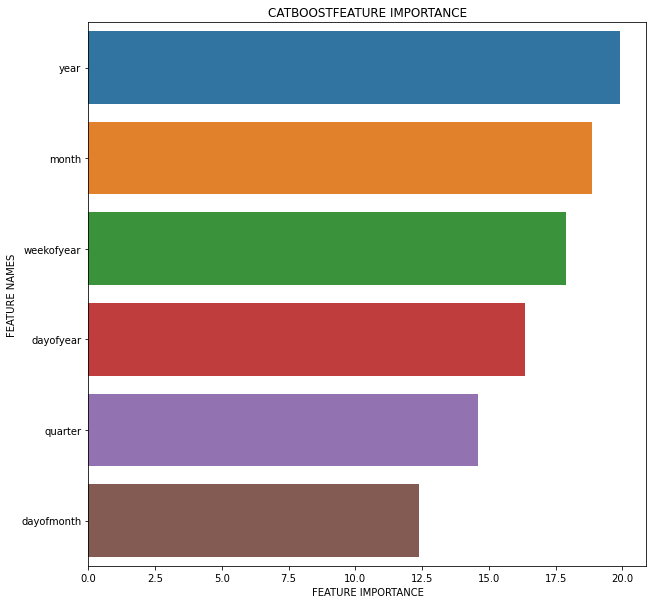

In [30]:
# Значимость признаков CatBoost в модели прогностики

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#plot the catboost result
plot_feature_importance(model_test.get_feature_importance(),x_train_all.columns,'CATBOOST')

In [24]:
# создание колонки прогнозов
test['Prognoz']=model_test.predict(x_test_all)

In [25]:
test

,Цена на арматуру,dt,Data_Time,quarter,month,year,dayofyear,dayofmonth,weekofyear,Prognoz
0,46000,09.05.2022,2022-09-05,3,9,2022,248,5,36,больше
1,46000,09.12.2022,2022-09-12,3,9,2022,255,12,37,больше
2,46000,09.19.2022,2022-09-19,3,9,2022,262,19,38,меньше
3,45500,09.26.2022,2022-09-26,3,9,2022,269,26,39,меньше
4,45500,10.03.2022,2022-10-03,4,10,2022,276,3,40,больше
5,45000,10.10.2022,2022-10-10,4,10,2022,283,10,41,больше
6,44000,10.17.2022,2022-10-17,4,10,2022,290,17,42,меньше
7,43000,10.24.2022,2022-10-24,4,10,2022,297,24,43,больше
8,42000,10.31.2022,2022-10-31,4,10,2022,304,31,44,меньше
9,41500,11.07.2022,2022-11-07,4,11,2022,311,7,45,меньше


In [26]:
# сохранение модели
model_test.save_model('catboost_model.bin')

In [27]:
# сохранение прогноза
test_itog=test[['dt','Цена на арматуру','Prognoz']]
test_itog.to_csv('Выполненный прогноз тренда.csv', sep=';', index=None)